Date : June 15  
Author : Ashok

The following three cells are taken from the "Carroll4th Cloud Coverage Data-Copy1.ipynb" present [here](https://github.com/floodnet-nyc/Solar-Coverage-Data/blob/main/Carroll4th%20Cloud%20Coverage%20Data-Copy1.ipynb) but are modified to query data for any number of days one wants to. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision
from datetime import datetime, timedelta

sns.set(rc = {'figure.figsize':(18,10)})
%config InlineBackend.figure_format = 'retina'

In [7]:
def query_from_influxdb(_url=None,
                        _token=None,
                        _org=None,
                        _id=None,
                        _bucket_name=None,
                        _columns_to_drop=None,
                        _measurement=None,
                        _field=None,
                       _start = None):

    """
        Function to query InfluxDB using influxdb-python-client library from https://github.com/influxdata/influxdb-client-python
            :param _measurement: Available options are flood-sensor-tidal-sensor-rain-gauge,weather,etc. Default is flood-sensor
            :param _field: Available options include batt_v and cloud_percent
            :param _url: InfluxDB url
            :param _token: API token with read-access
            :param _org: InfluxDB organization name
            :param _id: Sensor/Deployment ID
            :param _bucket_name: Name of the bucket
            :param _columns_to_drop: Array-like column names to be dropped
            :param _start : Start time for the query,type : datetime
        :returns a dataframe with all columns except dropped ones if any
    """
    result = []

    p = {"_id_value": _id,
         "_bucket_name": _bucket_name,
         "_measurement": _measurement,
         "_field": _field,
        "_start": _start
        }


    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000, verify_ssl = False) as client:
        query_api = client.query_api()
        if _measurement=="weather":
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                  |> range(start: _start, stop: now())
                                                  |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                  |> filter(fn: (r) => r["_field"] == _field)
                                                  |> filter(fn: (r) => r["sensor_id"] == _id_value)
                                                  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)
        else:
            result = query_api.query_data_frame('''from(bucket: _bucket_name)
                                                |> range(start: _start)
                                                |> filter(fn: (r) => r["_measurement"] == _measurement)
                                                |> filter(fn: (r) => r["deployment_id"] == _id_value)
                                                |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                                ''', params=p)

        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True) #result
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])

    return result

In [8]:
sensor_location_data = pd.read_csv("Sensor Locations Directory - Internal - street sensors (live).csv")
for deployment_id in sensor_location_data['deployment_id']:
    print(deployment_id)

-
daily_gentle_beetle
widely_proud_lizard
overly_heroic_squid
weekly_poetic_guinea
vastly_saving_whale
openly_driven_tarpon
jolly_tender_squid
daily_new_falcon
early_still_frog
really_vocal_puma
gladly_mint_snail
evenly_divine_dingo
weekly_fair_dove
daily_mutual_gnat
mainly_whole_slug
slowly_fast_sawfly
easily_cosmic_slug
duly_star_bee
simply_pet_joey
mildly_calm_ibex
mainly_fond_boar
duly_pro_vervet
easily_dear_mouse
total_moccasin_dolphin
handsome_violet_leech
boring_olive_stingray
tired_red_monkey
bored_blue_fish
daily_happy_satyr
ugliest_cyan_elephant
asleep_apricot_bedbug
future_aqua_wildcat
disabled_pink_prawn
useless_crimson_rook
mean_flying_fish
closed_wagon_snail
clearly_bored_turtle
blue_eyed_tiger
simply_half_monkey
total_melt_deer
light_maroon_penguin
unified_angry_donkey
big_pink_elephant
lonely_quiet_bear
small_red_chicken
random_stuck_buffalo
(not yet live)
jolly-novel-boa
likely-well-thrush
sadly-direct-walrus
poorly_sunny_earwig
highly_comic_akita
widely_full_weevil
pu

In [13]:
start_day = 30 ##number of days for which you want to get the data 

# Get the current date and time
current_datetime = datetime.now()

# Calculate the date and time exactly start_days days ago
start_time = current_datetime - timedelta(days = start_day)

for deployment_id in sensor_location_data['deployment_id']:
    try:
        retrived_df= query_from_influxdb(_url='https://influxdb.floodlabs.nyc/',
                           _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                       _org='floodnet',
                       _id= deployment_id,
                      _bucket_name='floodnet-live',
                       _measurement="flood-sensor",
                        _start = start_time,
                       _field="batt_v",).reset_index()[['time', 'batt_v', 'depth_filt_mm', 'dist_mm', 'f_cnt', 'gw_1_rssi_dbm', 'gw_1_snr_db','gw_2_rssi_dbm', 'gw_2_snr_db','gw_3_rssi_dbm', 'gw_3_snr_db','deployment_id']]


        retrived_df['times'] = retrived_df['time'].dt.time
        retrived_df['date'] = retrived_df['time'].dt.date

        file_path = deployment_id + ".csv"
        retrived_df.to_csv(file_path)
        print("saved" + file_path)
    except KeyError:
        pass

saveddaily_gentle_beetle.csv
savedoverly_heroic_squid.csv
savedweekly_poetic_guinea.csv
savedvastly_saving_whale.csv
savedopenly_driven_tarpon.csv
savedjolly_tender_squid.csv
saveddaily_new_falcon.csv
savedgladly_mint_snail.csv
savedeasily_dear_mouse.csv
savedbored_blue_fish.csv
saveddaily_happy_satyr.csv
savedmean_flying_fish.csv
savedclosed_wagon_snail.csv
savedclearly_bored_turtle.csv
savedblue_eyed_tiger.csv
savedsimply_half_monkey.csv
savedtotal_melt_deer.csv
savedlight_maroon_penguin.csv
savedlovely_helped_lamb.csv
saveddaily_ace_bear.csv


<AxesSubplot:xlabel='time', ylabel='depth_filt_mm'>

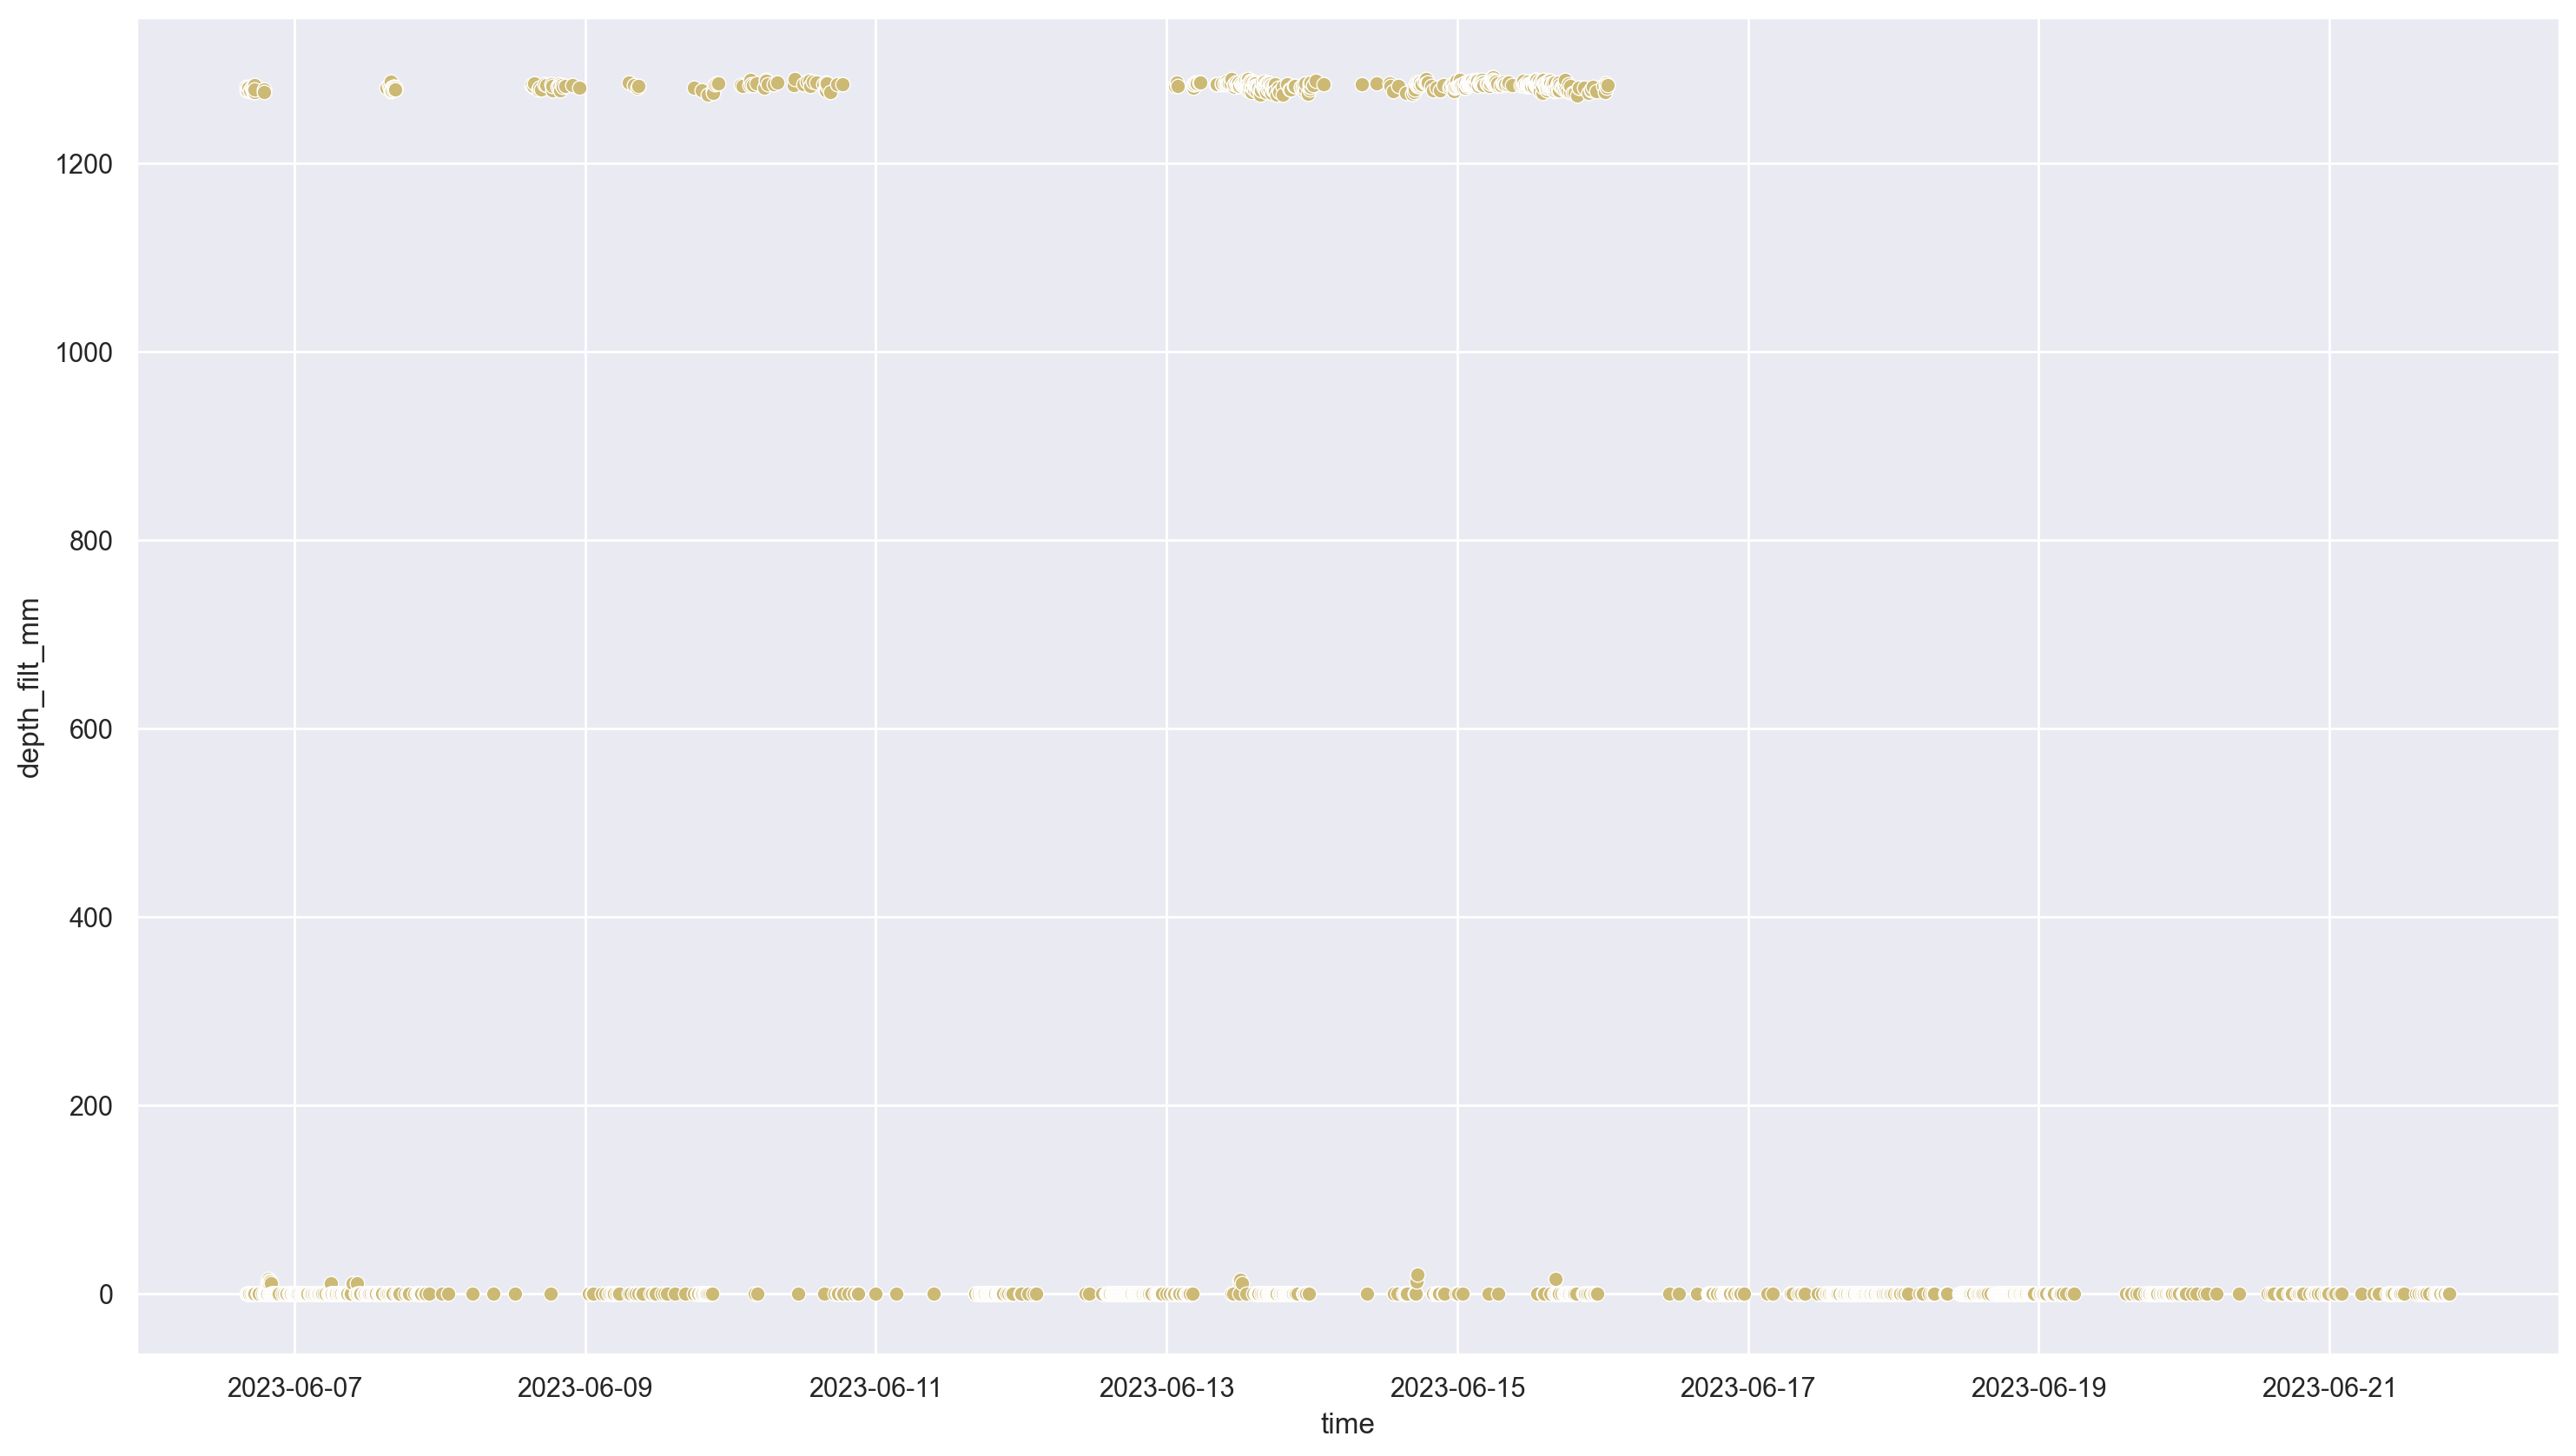

In [56]:

sns.scatterplot(x = "time", y = "depth_filt_mm", color = 'y', data = retrived_df)
  

<AxesSubplot:xlabel='time', ylabel='smooth_rssi'>

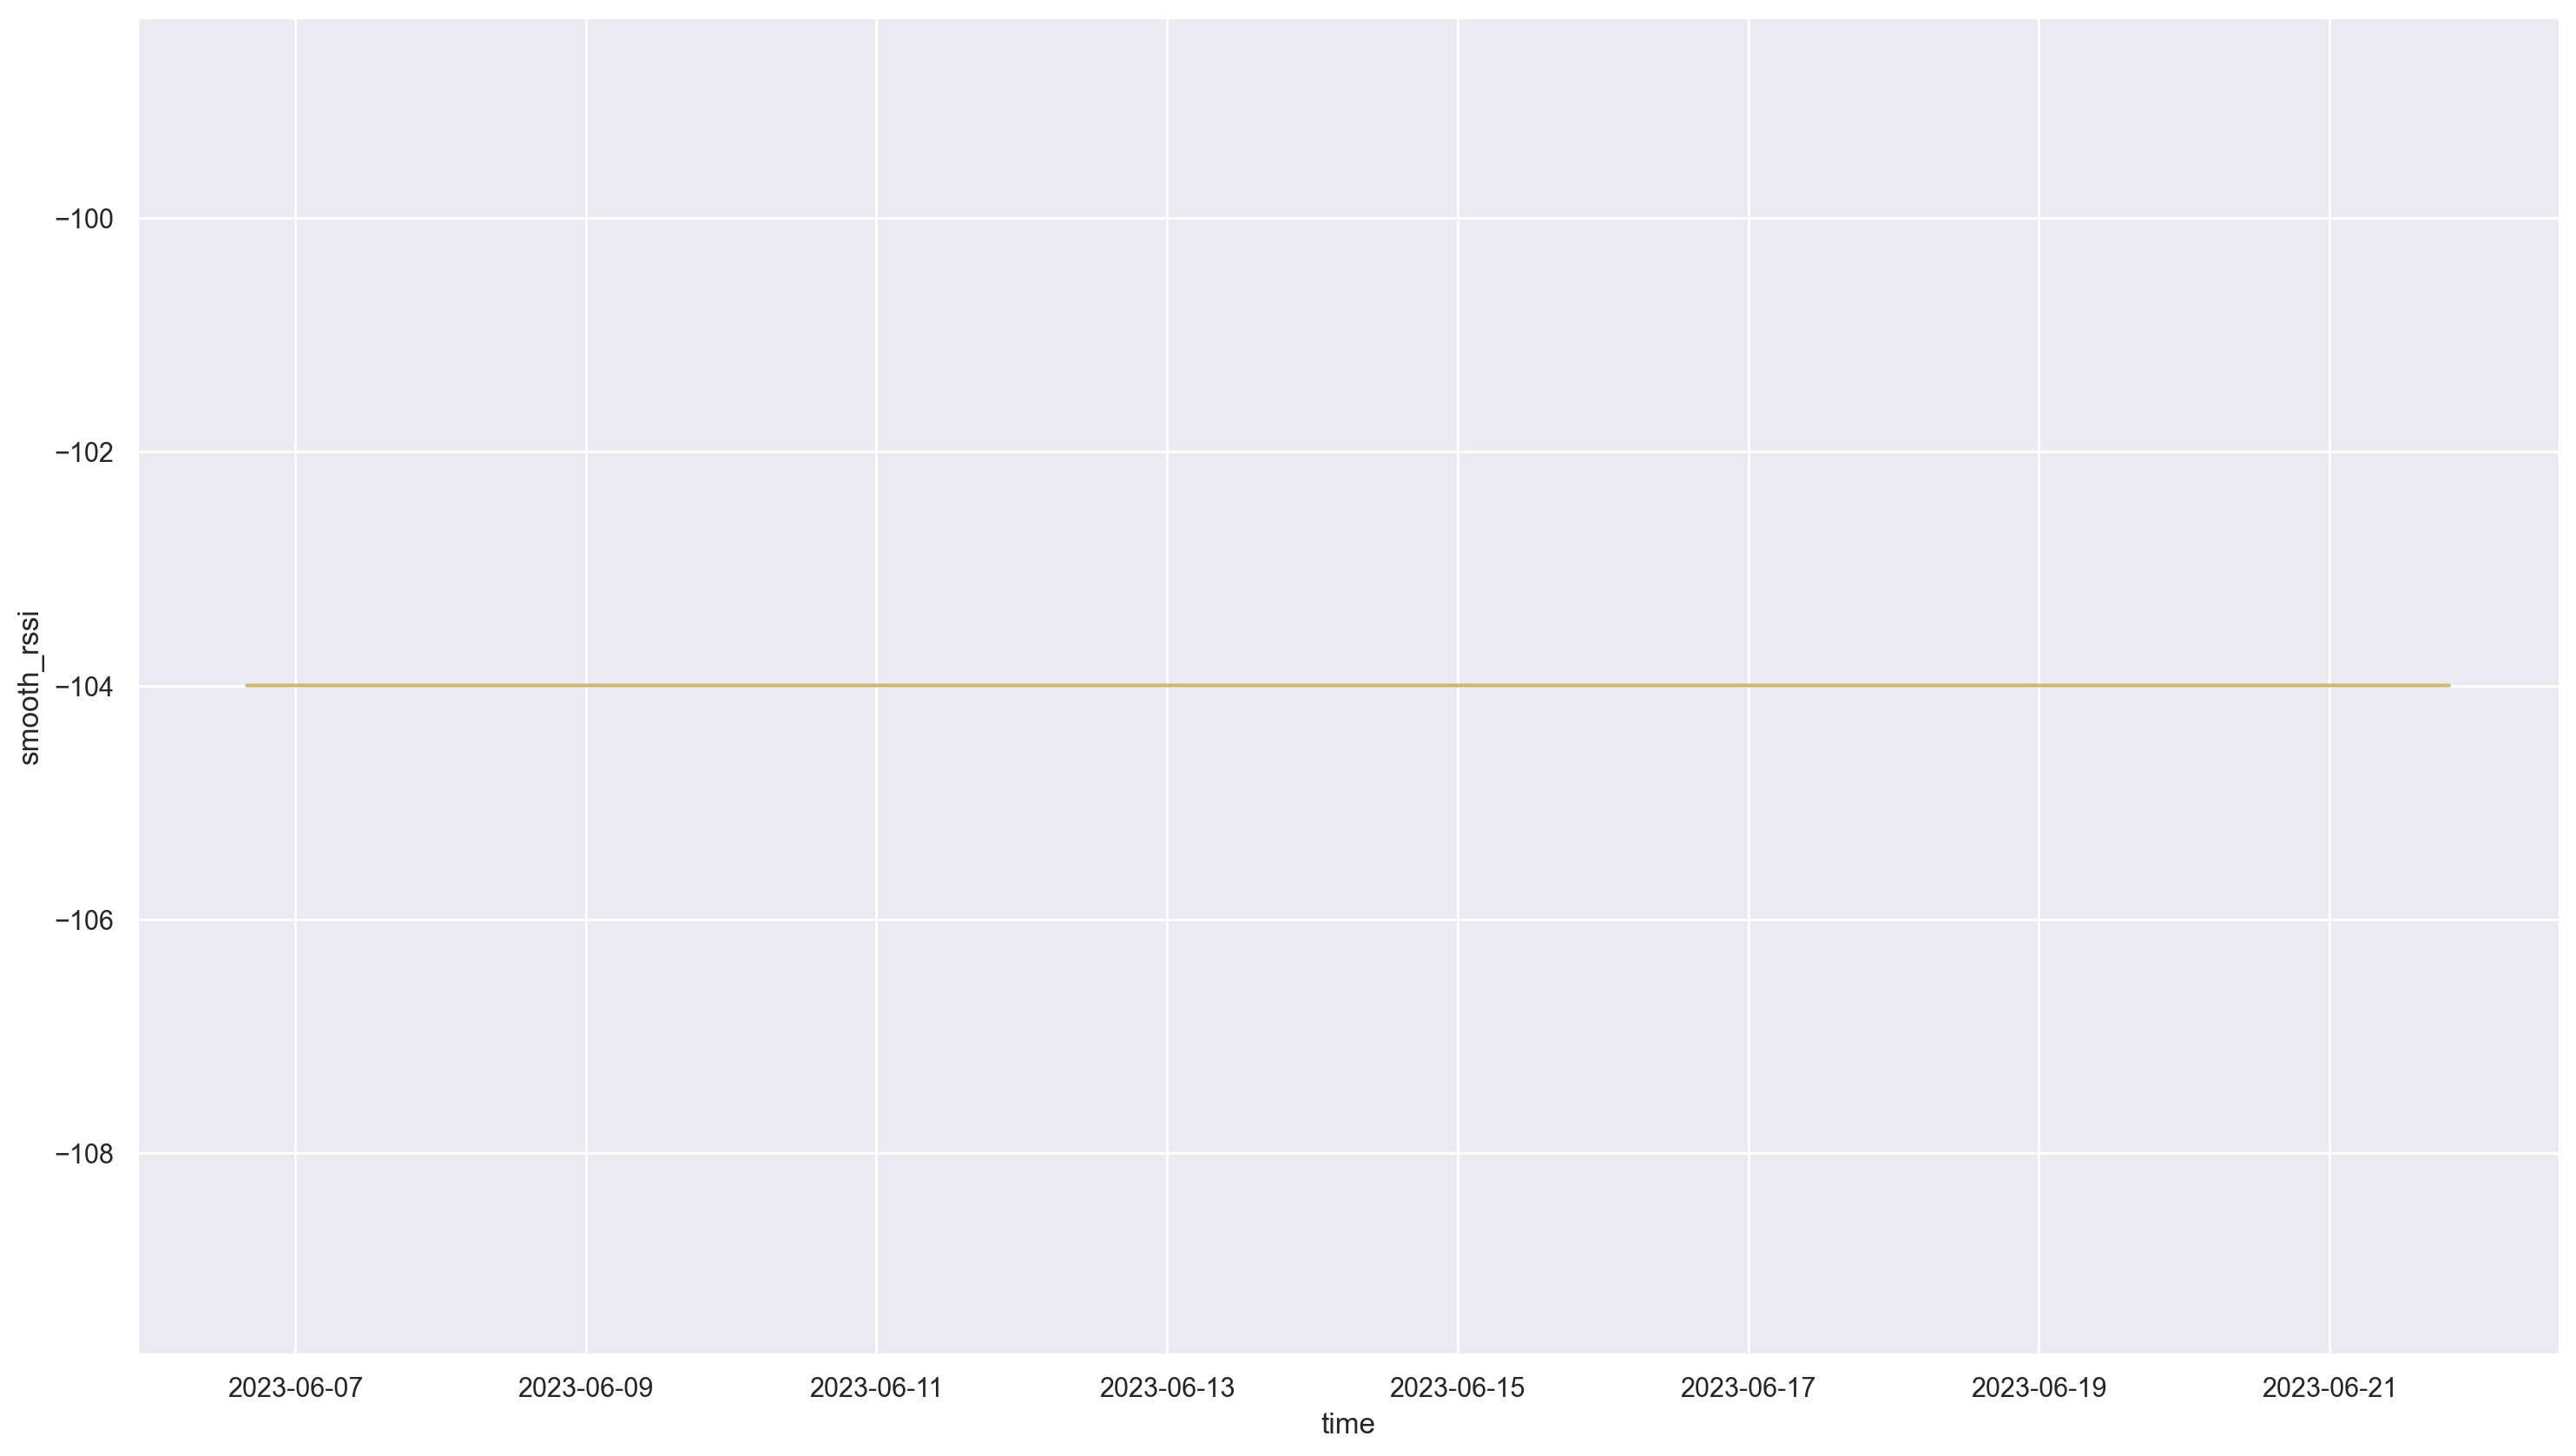

In [57]:
!pip install scipy
from scipy.ndimage import gaussian_filter1d
retrived_df['smooth_rssi'] = gaussian_filter1d(retrived_df['gw_1_rssi_dbm'], sigma=1000)
sns.lineplot(x = "time", y = "smooth_rssi", color = 'y', data = retrived_df)

In [58]:
retrived_df['datetime'] = pd.to_datetime(retrived_df['time'])
# retrived_df['datetime']

retrived_df['times'] = retrived_df['time'].dt.time
retrived_df['date'] = retrived_df['time'].dt.date

In [59]:
retrived_df['date'] = [str(i) for i in retrived_df['date']]
retrived_df.head()

time  dist_mm  gw_1_rssi_dbm  depth_filt_mm  \
0 2023-06-06 16:02:58.845000+00:00      991           -104           1281   
1 2023-06-06 16:08:14.651000+00:00      994           -105           1278   
2 2023-06-06 16:10:20.607000+00:00     5000           -102              0   
3 2023-06-06 16:11:23.124000+00:00      994            -98           1278   
4 2023-06-06 16:15:34.840000+00:00     5000           -103              0   

   depth_proc_mm            times        date  smooth_rssi  \
0              0  16:02:58.845000  2023-06-06         -104   
1              0  16:08:14.651000  2023-06-06         -104   
2              0  16:10:20.607000  2023-06-06         -104   
3              0  16:11:23.124000  2023-06-06         -104   
4              0  16:15:34.840000  2023-06-06         -104   

                          datetime  
0 2023-06-06 16:02:58.845000+00:00  
1 2023-06-06 16:08:14.651000+00:00  
2 2023-06-06 16:10:20.607000+00:00  
3 2023-06-06 16:11:23.124000+00:00  
4 2023-06-06 16:15:34.840000+00:00

In [60]:
retrived_df.to_csv('daily_gentle_beetle.csv', index=False)

In [61]:
retrived_df.columns.tolist()

['time',
 'dist_mm',
 'gw_1_rssi_dbm',
 'depth_filt_mm',
 'depth_proc_mm',
 'times',
 'date',
 'smooth_rssi',
 'datetime']

In [62]:
desired_dates = ['2023-06-12','2023-06-11', '2023-06-13', '2023-06-10', '2023-06-09', '2023-06-14','2023-06-15']

#desired_dates = [ '2023-06-16','2023-06-15']

print(desired_dates)
df1 = retrived_df[retrived_df['date'].isin(desired_dates)]

['2023-06-12', '2023-06-11', '2023-06-13', '2023-06-10', '2023-06-09', '2023-06-14', '2023-06-15']


In [63]:
df1.head(100)

time  dist_mm  gw_1_rssi_dbm  depth_filt_mm  \
290 2023-06-09 00:34:35.546000+00:00     2266           -111              0   
291 2023-06-09 01:08:10.125000+00:00     2275           -109              0   
292 2023-06-09 01:21:48.899000+00:00     2274           -111              0   
293 2023-06-09 02:46:51.841000+00:00     2267           -110              0   
294 2023-06-09 03:19:22.901000+00:00     2273           -113              0   
..                               ...      ...            ...            ...   
385 2023-06-10 16:24:23.083000+00:00      996           -105           1276   
386 2023-06-10 17:12:39.951000+00:00     2272           -104              0   
387 2023-06-10 17:33:47.691000+00:00     5000           -102              0   
388 2023-06-10 17:40:05.554000+00:00      988           -104           1284   
389 2023-06-10 17:45:20.338000+00:00     5000           -103              0   

     depth_proc_mm            times        date  smooth_rssi  \
290              0  00:34:35.546000  2023-06-09         -104   
291              0  01:08:10.125000  2023-06-09         -104   
292              0  01:21:48.899000  2023-06-09         -104   
293              0  02:46:51.841000  2023-06-09         -104   
294              0  03:19:22.901000  2023-06-09         -104   
..             ...              ...         ...          ...   
385              0  16:24:23.083000  2023-06-10         -104   
386              0  17:12:39.951000  2023-06-10         -104   
387              0  17:33:47.691000  2023-06-10         -104   
388              0  17:40:05.554000  2023-06-10         -104   
389              0  17:45:20.338000  2023-06-10         -104   

                            datetime  
290 2023-06-09 00:34:35.546000+00:00  
291 2023-06-09 01:08:10.125000+00:00  
292 2023-06-09 01:21:48.899000+00:00  
293 2023-06-09 02:46:51.841000+00:00  
294 2023-06-09 03:19:22.901000+00:00  
..                               ...  
385 2023-06-10 16:24:23.083000+00:00  
386 2023-06-10 17:12:39.951000+00:00  
387 2023-06-10 17:33:47.691000+00:00  
388 2023-06-10 17:40:05.554000+00:00  
389 2023-06-10 17:45:20.338000+00:00  

[100 rows x 9 columns]

In [65]:
df1

time  dist_mm  gw_1_rssi_dbm  depth_filt_mm  \
290  2023-06-09 00:34:35.546000+00:00     2266           -111              0   
291  2023-06-09 01:08:10.125000+00:00     2275           -109              0   
292  2023-06-09 01:21:48.899000+00:00     2274           -111              0   
293  2023-06-09 02:46:51.841000+00:00     2267           -110              0   
294  2023-06-09 03:19:22.901000+00:00     2273           -113              0   
...                               ...      ...            ...            ...   
1212 2023-06-15 22:28:17.504000+00:00     5000           -101              0   
1213 2023-06-15 22:44:01.719000+00:00     5000           -103              0   
1214 2023-06-15 22:57:39.849000+00:00      995           -105           1277   
1215 2023-06-15 22:58:43.045000+00:00     5000           -107              0   
1216 2023-06-15 23:05:01.908000+00:00     5000           -105              0   

      depth_proc_mm            times        date  smooth_rssi  \
290               0  00:34:35.546000  2023-06-09         -104   
291               0  01:08:10.125000  2023-06-09         -104   
292               0  01:21:48.899000  2023-06-09         -104   
293               0  02:46:51.841000  2023-06-09         -104   
294               0  03:19:22.901000  2023-06-09         -104   
...             ...              ...         ...          ...   
1212              0  22:28:17.504000  2023-06-15         -104   
1213              0  22:44:01.719000  2023-06-15         -104   
1214              0  22:57:39.849000  2023-06-15         -104   
1215              0  22:58:43.045000  2023-06-15         -104   
1216              0  23:05:01.908000  2023-06-15         -104   

                             datetime  
290  2023-06-09 00:34:35.546000+00:00  
291  2023-06-09 01:08:10.125000+00:00  
292  2023-06-09 01:21:48.899000+00:00  
293  2023-06-09 02:46:51.841000+00:00  
294  2023-06-09 03:19:22.901000+00:00  
...                               ...  
1212 2023-06-15 22:28:17.504000+00:00  
1213 2023-06-15 22:44:01.719000+00:00  
1214 2023-06-15 22:57:39.849000+00:00  
1215 2023-06-15 22:58:43.045000+00:00  
1216 2023-06-15 23:05:01.908000+00:00  

[927 rows x 9 columns]

In [66]:
sns.set(rc = {'figure.figsize':(18,10)})

sns.scatterplot(x='time', y='batt_v', data = df1, )
plt.xticks(rotation=45)
plt.show()

ValueError: Could not interpret value `batt_v` for parameter `y`

<AxesSubplot:xlabel='time', ylabel='gw_1_rssi_dbm'>

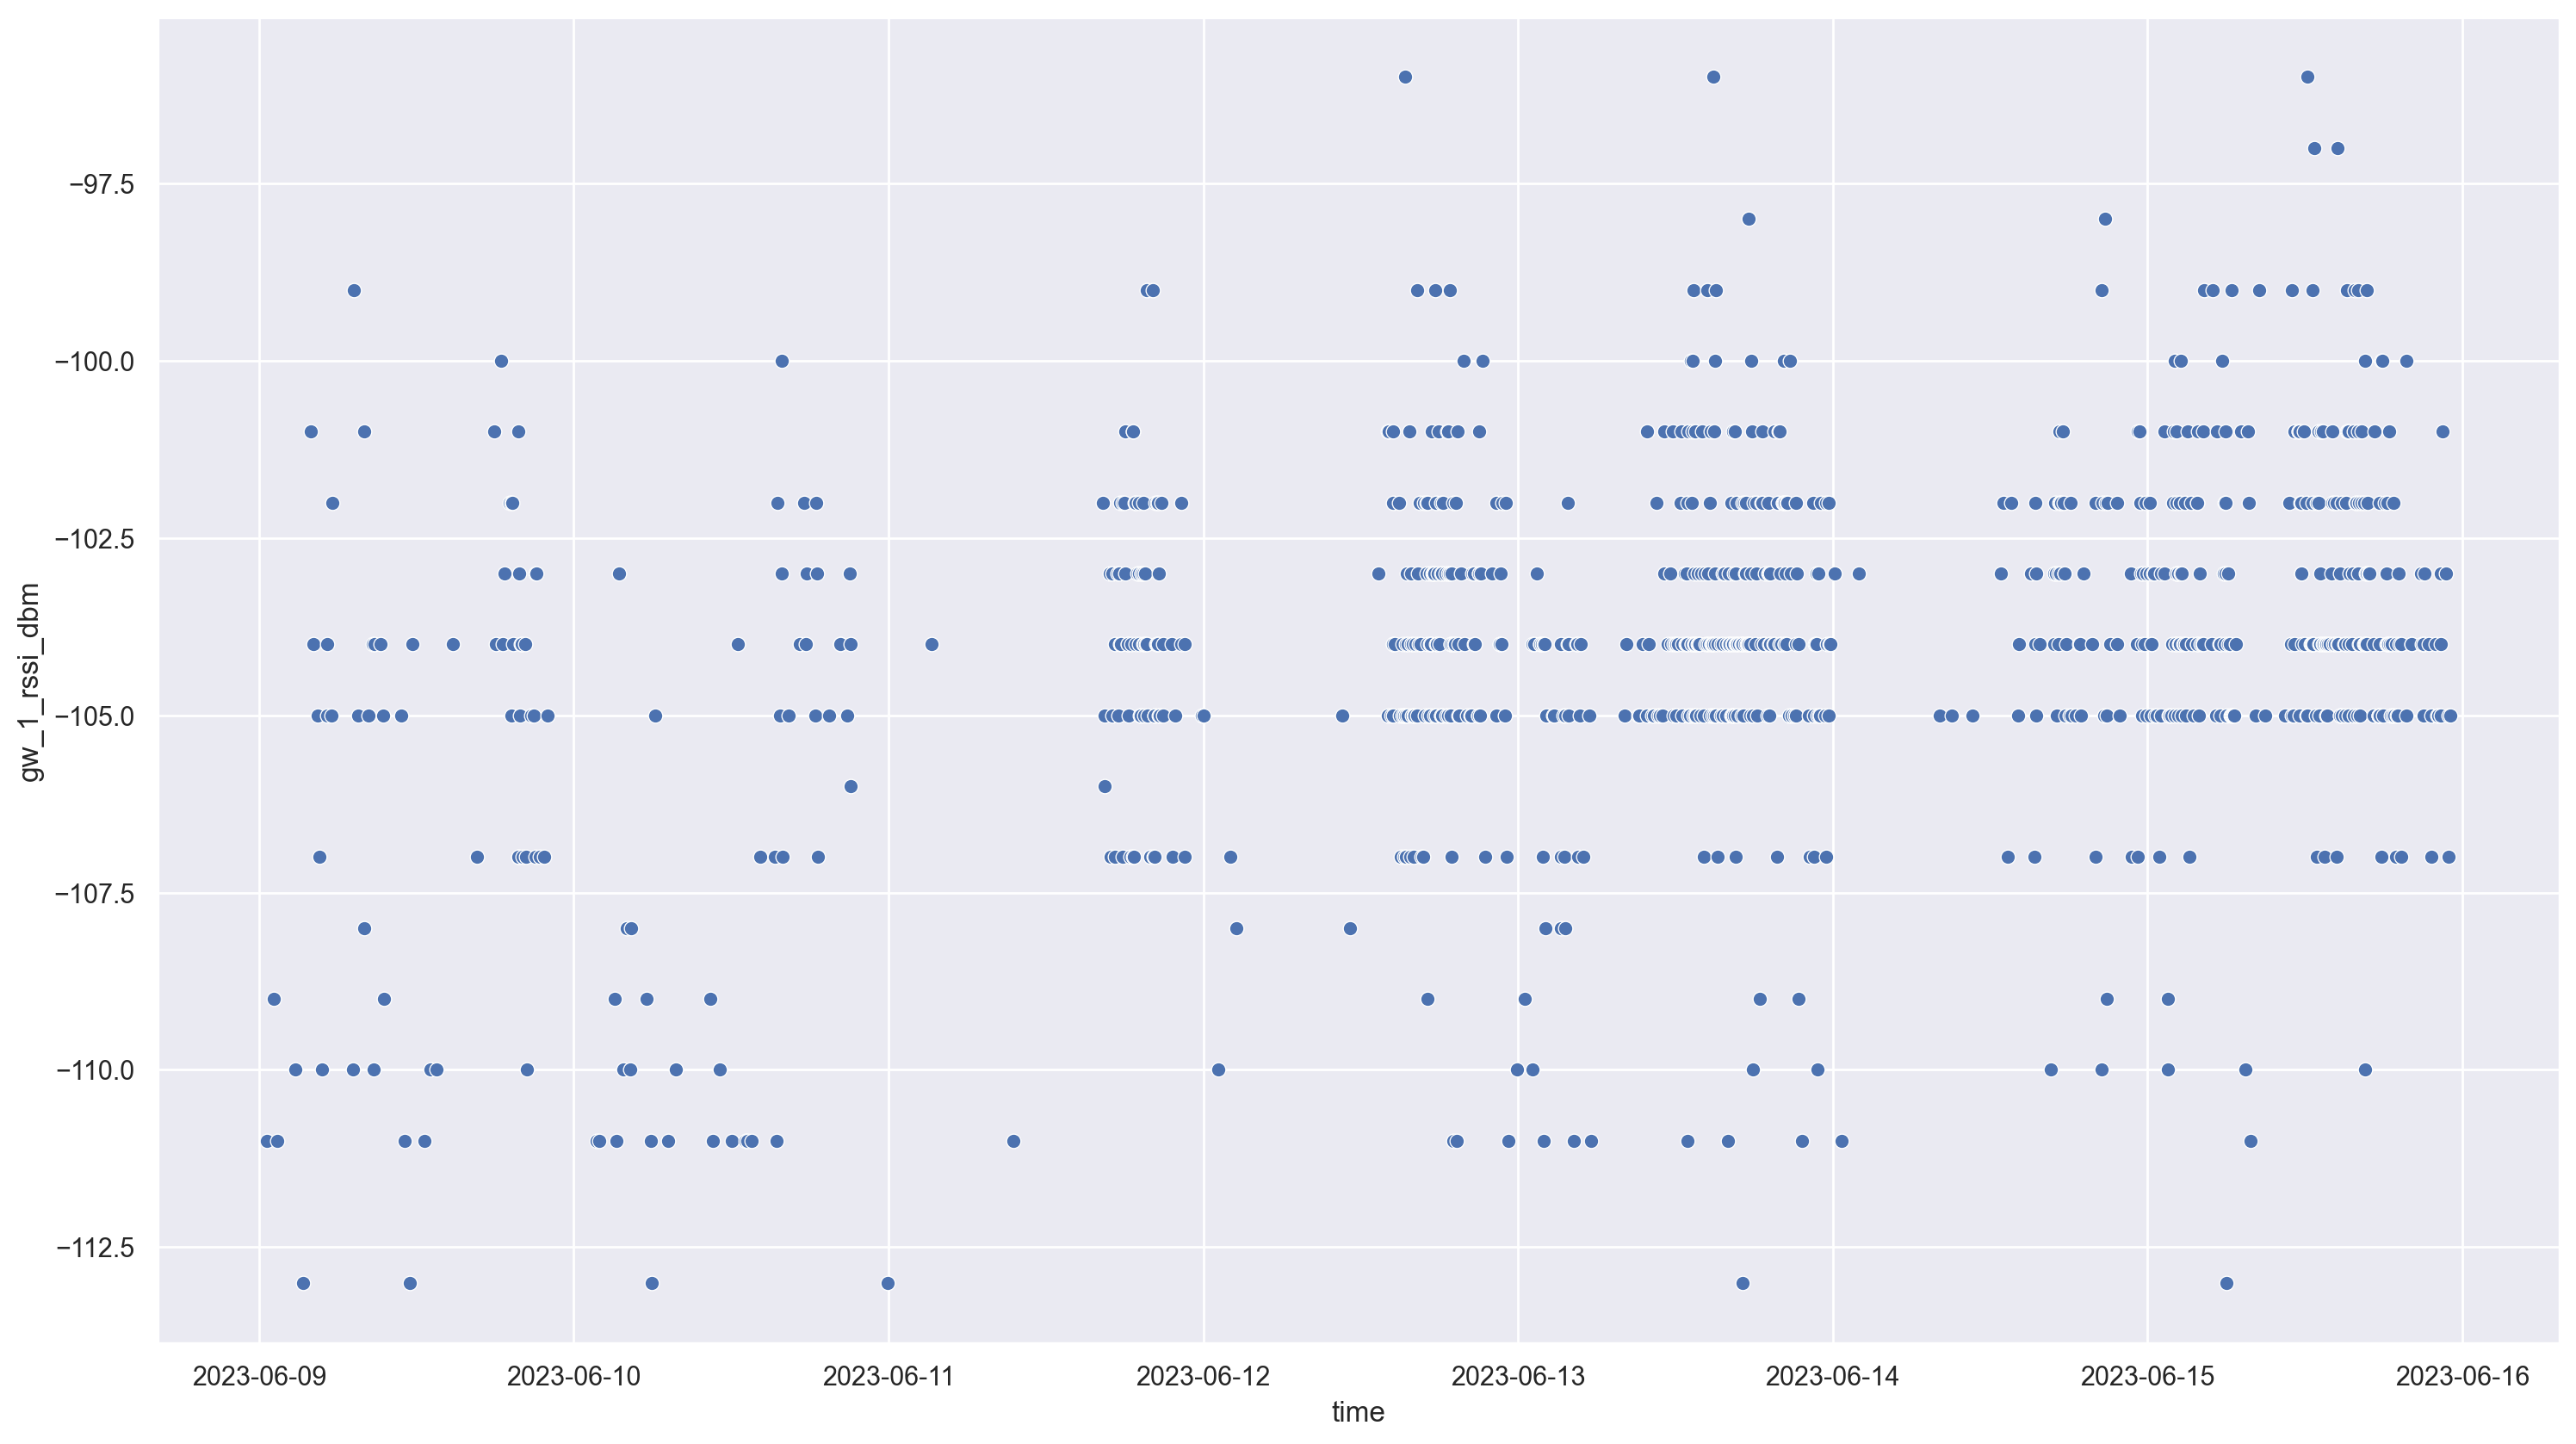

In [67]:
sns.scatterplot(x='time', y='gw_1_rssi_dbm', data = df1[df1['gw_1_rssi_dbm'] < 0], )


<AxesSubplot:xlabel='time', ylabel='depth_filt_mm'>

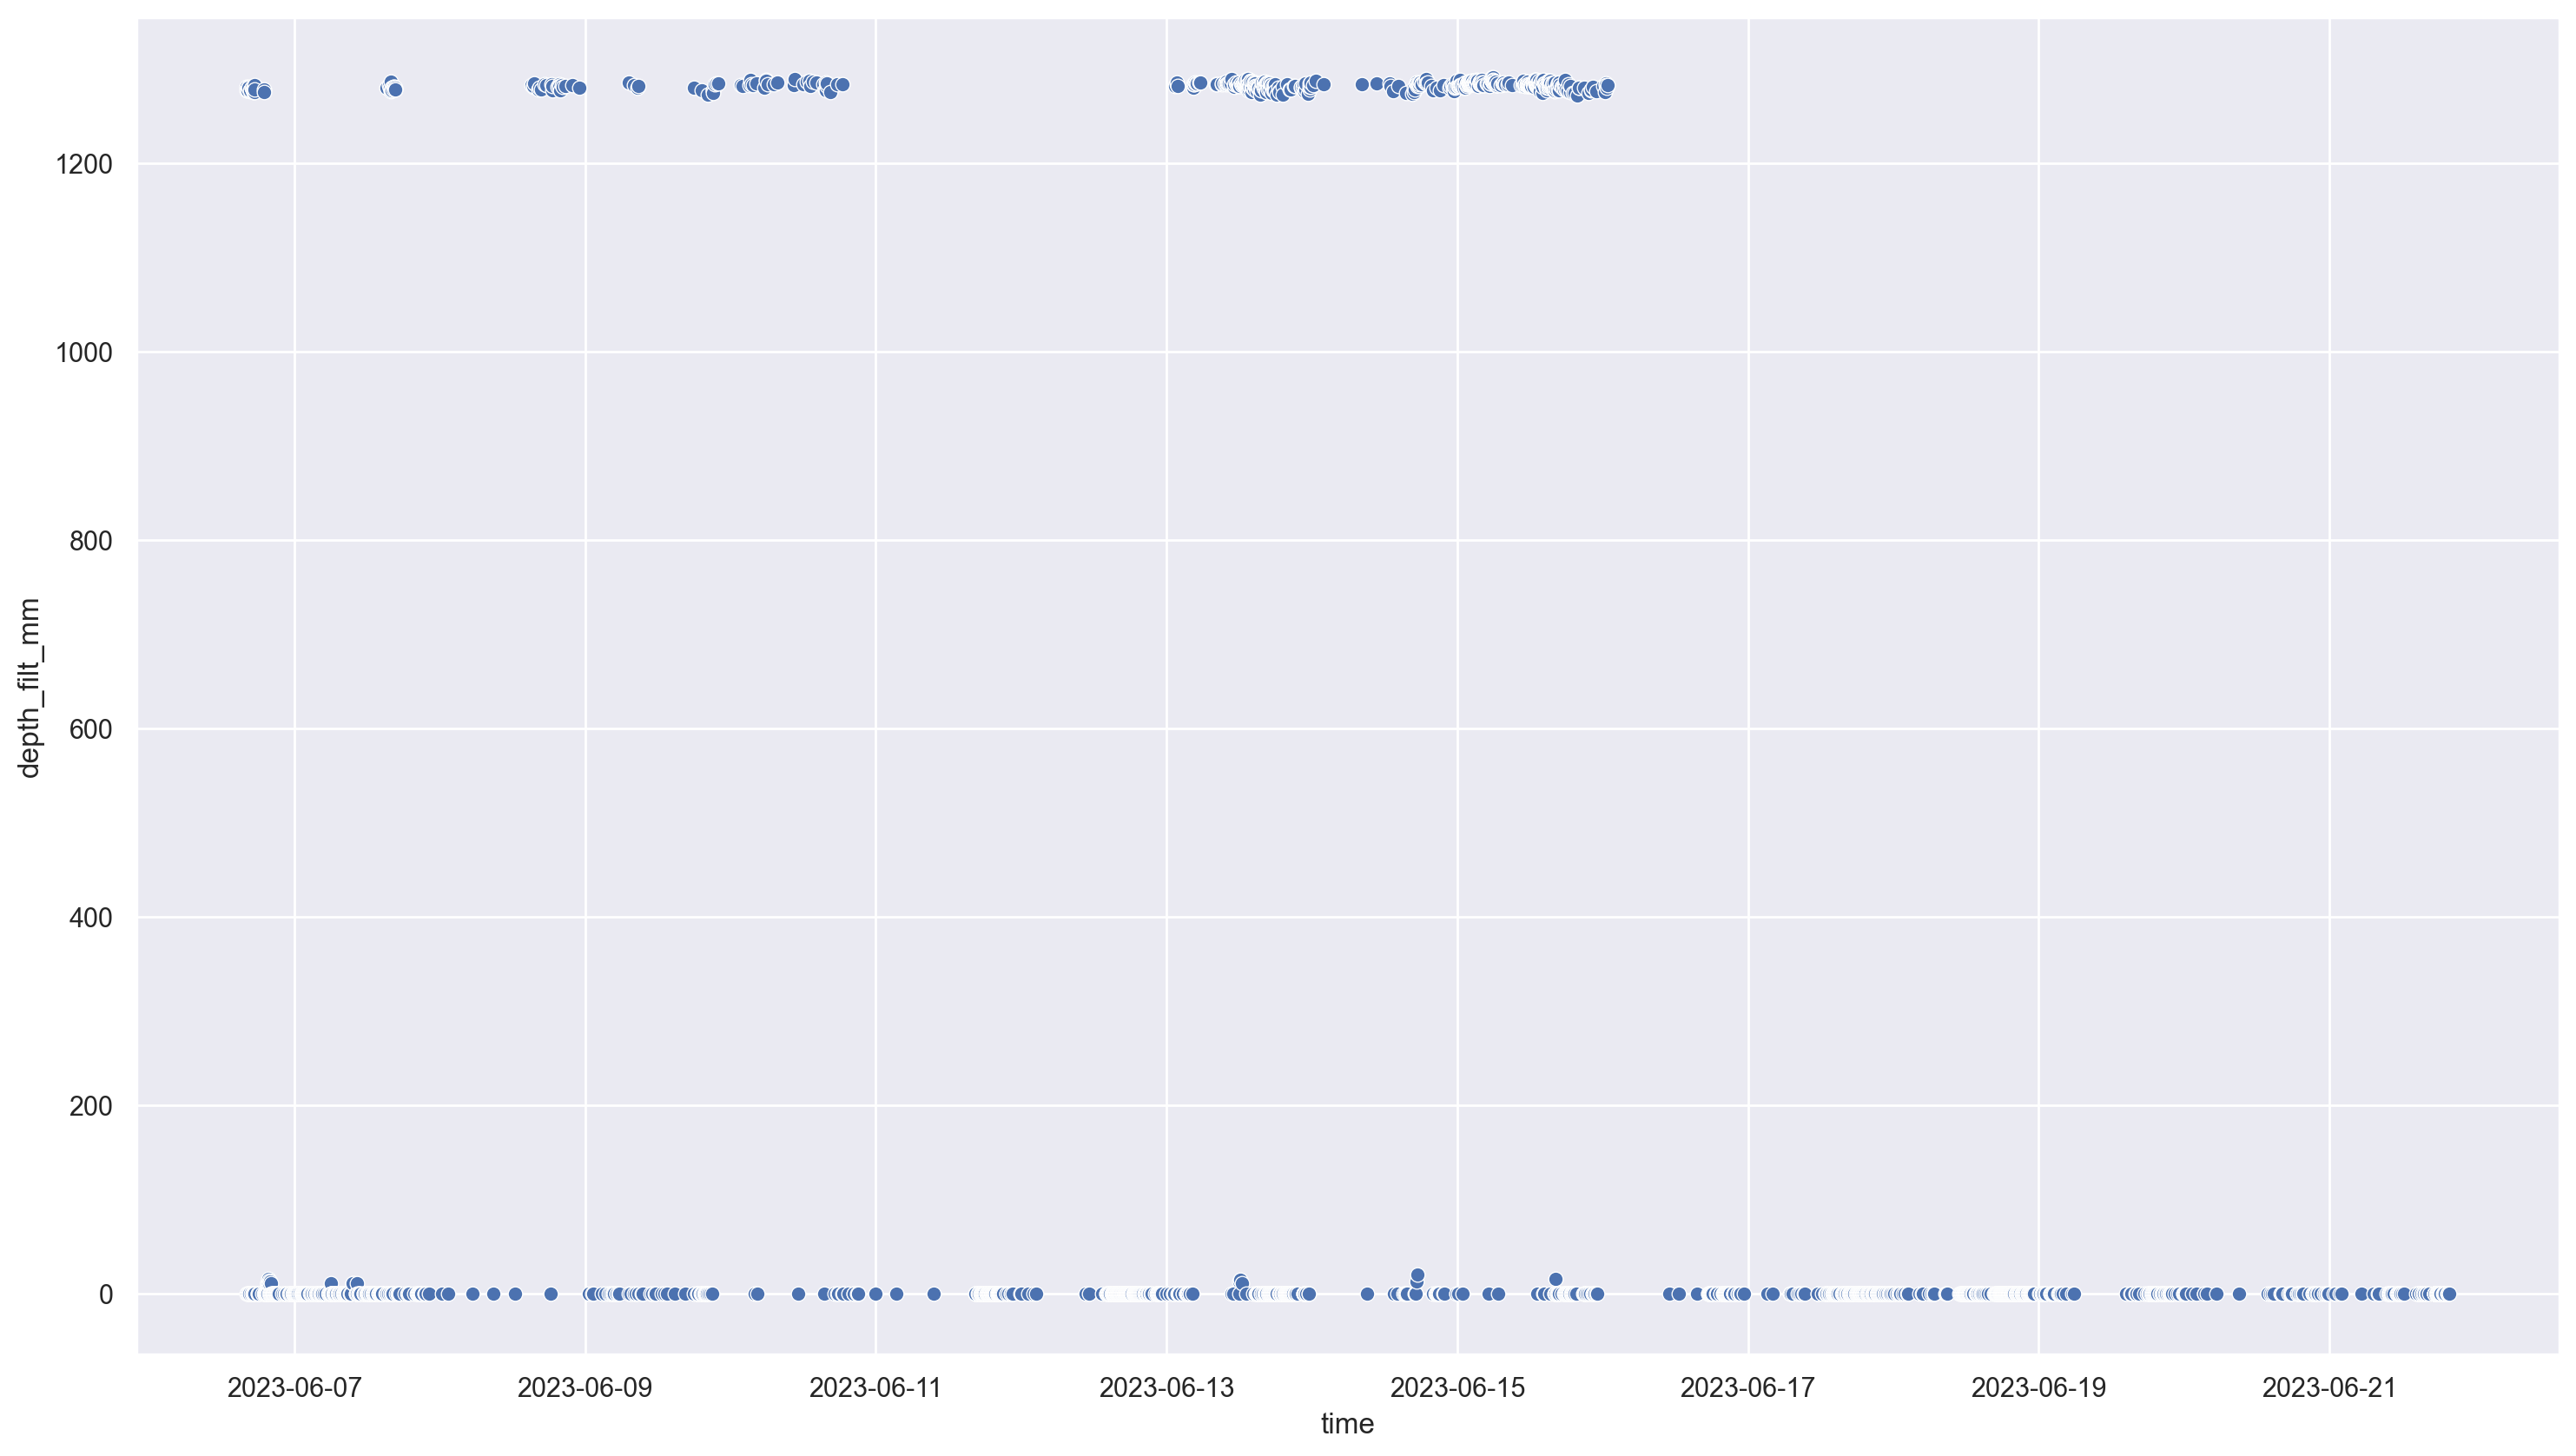

In [68]:
sns.scatterplot(x='time', y='depth_filt_mm', data = retrived_df, )